In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from rbf import TLoc


In [5]:
data = pd.read_csv("data.csv", index_col=0)
min_value = data.iloc[:, 5:].min().min()
data = data.fillna(min_value - 1)
data.iloc[:, 5:] = data.iloc[:, 5:] + (min_value - 1)*(-1)

In [6]:
name_mac_relation = pd.read_csv("mac_name_relation.csv", index_col=0)
good_aps = name_mac_relation[name_mac_relation['ap_name'].isin( ["Guest-CentraleSupelec", "eduroam", 'stop&go', 'CD91', 'fabrique2024'])]["ap_mac"].to_list()
columns_to_maintain  = good_aps + data.columns[:5].to_list()
data = data[data.columns.intersection(columns_to_maintain)]

In [7]:
AP_columns = list(data.columns[5:])
non_AP_columns = list(data.columns[:5])

data = data[data["room_part"] != 5]

# Pre processing

In [14]:
data_to_remove_outliers = data.groupby(["room", "room_part", "device_id"])

aux = []
for name, data_grouped in data_to_remove_outliers:
    data_grouped = data_grouped.reset_index()
    mean = data_grouped[AP_columns].mean()
    
    for ap in AP_columns:
        if mean[ap] > 5:
            for i in range(len(data_grouped)):
                if data_grouped.at[i, ap] == 0:
                    # Find the nearest non-zero value
                    nearest_non_zero = None
                    left_index = i - 1
                    right_index = i + 1
                    
                    while nearest_non_zero is None:
                        if left_index >= 0 and data_grouped.at[left_index, ap] != 0:
                            nearest_non_zero = data_grouped.at[left_index, ap]
                        elif right_index < len(data_grouped) and data_grouped.at[right_index, ap] != 0:
                            nearest_non_zero = data_grouped.at[right_index, ap]
                        else:
                            left_index -= 1
                            right_index += 1
                    
                    # Replace the zero value with the nearest non-zero value
                    data_grouped.at[i, ap] = nearest_non_zero

    aux.append(data_grouped)


data_filtered_without_outliers = pd.concat(aux, ignore_index=True)


    

In [15]:
data_to_filter = data_filtered_without_outliers.groupby(["room", "room_part", "device_id"])

aux = []
alpha = 0.5
for name, data_grouped in data_to_filter:
    # data_filtered.loc[len(data_filtered.index)] = data_grouped.iloc[0]
    filtered_values = data_grouped.iloc[0][AP_columns]
    for _, values in data_grouped.iterrows():
        filtered_values = alpha*values[AP_columns] + (1-alpha)*filtered_values
        # data_filtered.loc[len(data_filtered.index)] = list(values[non_AP_columns]) + list(filtered_values)
        aux.append(list(values[non_AP_columns]) + list(filtered_values))


data_filtered = pd.DataFrame(aux, columns=data.columns)

    

# Room Part Classification

In [8]:
data_grouped_by_room = data.groupby("room")

In [ ]:
results = dict()
results["KNN"] = dict()
results["Tloc"] = dict()





for id, room in data_grouped_by_room:
    print(id)
    results["KNN"][id] = dict()
    results["Tloc"][id] = dict()
    for device in data["device_id"].unique():
        train = room[room["device_id"] != device]
        test = room[room["device_id"] == device]
        # train, test = train_test_split(room, test_size=0.25, train_size=0.75, random_state=42, shuffle=True)
        if len(test) > 0:

            neigh = KNeighborsClassifier(n_neighbors=5)
            neigh.fit(train.iloc[:,5:], train['room_part'])
            predicted = neigh.predict(test.iloc[:,5:])
            ground_truth = test["room_part"].to_numpy()
            results["KNN"][id][device] = np.sum(predicted == ground_truth)/len(ground_truth)

            tloc = TLoc(train[["room_part"] + AP_columns], pred_class="room_part")
            tloc.train()
            accuracy, prediction, ground_truth = tloc.pred(test)
            results["Tloc"][id][device] = accuracy

In [10]:
results = {'KNN': {'LC410': {'V': 0.6203208556149733,
   'C': 0.352112676056338,
   'G': 0.27,
   'R': 0.5775},
  'LC412': {'V': 0.43466666666666665,
   'C': 0.3242506811989101,
   'G': 0.28211586901763225,
   'R': 0.405},
  'LC413': {'V': 0.425, 'C': 0.6525, 'G': 0.3775, 'R': 0.415},
  'LC414': {'V': 0.3113456464379947,
   'C': 0.1440443213296399,
   'G': 0.2931937172774869,
   'R': 0.24},
  'LC415': {'V': 0.3229166666666667,
   'C': 0.5122615803814714,
   'G': 0.2893401015228426,
   'R': 0.2725},
  'LC416': {'V': 0.4304461942257218,
   'C': 0.510989010989011,
   'G': 0.30402010050251255,
   'R': 0.48},
  'LC417': {'V': 0.4475, 'C': 0.6425, 'G': 0.36, 'R': 0.205},
  'LC424': {'V': 0.3325, 'C': 0.2975, 'G': 0.28, 'R': 0.305},
  'LC426': {'V': 0.2625, 'C': 0.4675, 'G': 0.3325, 'R': 0.465},
  'LC437': {'V': 0.4175, 'G': 0.345},
  'LC442': {'V': 0.2225, 'C': 0.4022727272727273, 'G': 0.33, 'R': 0.3625},
  'LC443': {'V': 0.6025, 'G': 0.65, 'R': 0.7525},
  'LC448': {'V': 0.4625, 'C': 0.37, 'G': 0.2625, 'R': 0.4375},
  'LC455': {'V': 0.4625, 'G': 0.51, 'R': 0.48}},
 'Tloc': {'LC410': {'V': 0.7620320855614974, 'C': 0.8, 'G': 0.27, 'R': 0.57},
  'LC412': {'V': 0.36533333333333334,
   'C': 0.5940054495912807,
   'G': 0.32997481108312343,
   'R': 0.5875},
  'LC413': {'V': 0.7675, 'C': 0.325, 'G': 0.4, 'R': 0.525},
  'LC414': {'V': 0.2559366754617414,
   'C': 0.3684210526315789,
   'G': 0.2905759162303665,
   'R': 0.4025},
  'LC415': {'V': 0.6822916666666666,
   'C': 0.5068119891008175,
   'G': 0.5,
   'R': 0.315},
  'LC416': {'V': 0.49868766404199477,
   'C': 0.5274725274725275,
   'G': 0.27638190954773867,
   'R': 0.525},
  'LC417': {'V': 0.7625, 'C': 0.4625, 'G': 0.42, 'R': 0.4275},
  'LC424': {'V': 0.6075, 'C': 0.3875, 'G': 0.355, 'R': 0.2975},
  'LC426': {'V': 0.51, 'C': 0.6575, 'G': 0.44, 'R': 0.3775},
  'LC437': {'V': 0.41, 'G': 0.25},
  'LC442': {'V': 0.41, 'C': 0.33181818181818185, 'G': 0.29, 'R': 0.3775},
  'LC443': {'V': 0.765, 'G': 0.7325, 'R': 0.82},
  'LC448': {'V': 0.4225, 'C': 0.2525, 'G': 0.2625, 'R': 0.295},
  'LC455': {'V': 0.295, 'G': 0.445, 'R': 0.6875}}}

{'V': {'KNN': {'LC410': 0.6203208556149733, 'LC412': 0.43466666666666665, 'LC413': 0.425, 'LC414': 0.3113456464379947, 'LC415': 0.3229166666666667, 'LC416': 0.4304461942257218, 'LC417': 0.4475, 'LC424': 0.3325, 'LC426': 0.2625, 'LC437': 0.4175, 'LC442': 0.2225, 'LC443': 0.6025, 'LC448': 0.4625, 'LC455': 0.4625}, 'Tloc': {'LC410': 0.7620320855614974, 'LC412': 0.36533333333333334, 'LC413': 0.7675, 'LC414': 0.2559366754617414, 'LC415': 0.6822916666666666, 'LC416': 0.49868766404199477, 'LC417': 0.7625, 'LC424': 0.6075, 'LC426': 0.51, 'LC437': 0.41, 'LC442': 0.41, 'LC443': 0.765, 'LC448': 0.4225, 'LC455': 0.295}}, 'C': {'KNN': {'LC410': 0.352112676056338, 'LC412': 0.3242506811989101, 'LC413': 0.6525, 'LC414': 0.1440443213296399, 'LC415': 0.5122615803814714, 'LC416': 0.510989010989011, 'LC417': 0.6425, 'LC424': 0.2975, 'LC426': 0.4675, 'LC437': nan, 'LC442': 0.4022727272727273, 'LC443': nan, 'LC448': 0.37, 'LC455': nan}, 'Tloc': {'LC410': 0.8, 'LC412': 0.5940054495912807, 'LC413': 0.325, 'LC

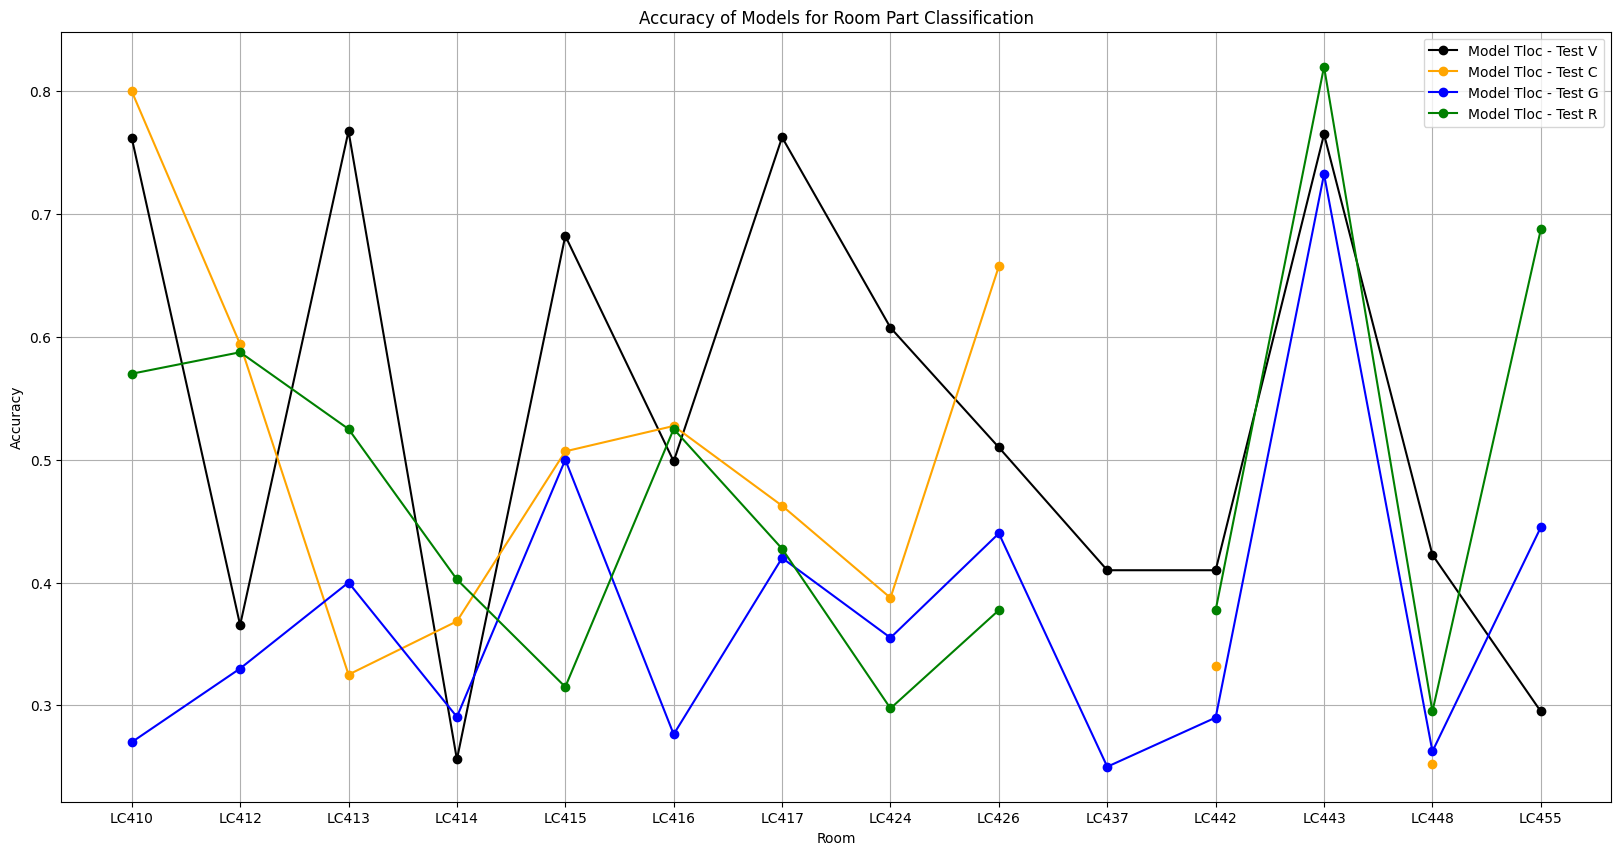

In [35]:
# Coletando as classes e acurácias
classes = []
accuracies = {}


for model, model_data in results.items():
    for class_name, class_data in model_data.items():
        for dataset, accuracy in class_data.items():
            if dataset not in accuracies:
                accuracies[dataset] = {}
            if model not in accuracies[dataset]:
                accuracies[dataset][model] = {}
            accuracies[dataset][model][class_name] = accuracy

for dataset, dataset_data in accuracies.items():
    for model, class_data in dataset_data.items():
        if not classes:
            classes = list(class_data.keys())
        else:
            classes = sorted(set(classes) | set(class_data.keys()))


for dataset, dataset_data in accuracies.items():
    for model, class_data in dataset_data.items():
        for class_name in classes:
            if class_name not in class_data:
                class_data[class_name] = np.nan
        accuracies[dataset][model] = {class_name: class_data[class_name] for class_name in classes}



print(accuracies)





colors = {
    "G": "blue",
    "C": "orange",
    "R": "green",
    "V": "black"
}

# Estilos de linha para cada modelo
styles = {
    "KNN": "--",
    "Tloc": "-",

}

# Preparando o gráfico
plt.figure(figsize=(20, 10))


# Plotando os dados
for dataset, dataset_data in accuracies.items():
    for model, class_data in dataset_data.items():
        if model =="Tloc":
            plt.plot(classes, list(class_data.values()), label=f'Model {model} - Test {dataset}',
                  linestyle=styles[model], color=colors[dataset], marker="o")



# Adicionando legendas e rótulos
plt.xlabel('Room')
plt.ylabel('Accuracy')
plt.title('Accuracy of Models for Room Part Classification')
plt.legend()

# Exibindo o gráfico
plt.grid(True)
plt.show()


In [33]:
{'V': {'KNN': {'LC410': 0.6203208556149733, 'LC412': 0.43466666666666665, 'LC413': 0.425, 'LC414': 0.3113456464379947, 'LC415': 0.3229166666666667, 'LC416': 0.4304461942257218, 'LC417': 0.4475, 'LC424': 0.3325, 'LC426': 0.2625, 'LC437': 0.4175, 'LC442': 0.2225, 'LC443': 0.6025, 'LC448': 0.4625, 'LC455': 0.4625}, 'Tloc': {'LC410': 0.7620320855614974, 'LC412': 0.36533333333333334, 'LC413': 0.7675, 'LC414': 0.2559366754617414, 'LC415': 0.6822916666666666, 'LC416': 0.49868766404199477, 'LC417': 0.7625, 'LC424': 0.6075, 'LC426': 0.51, 'LC437': 0.41, 'LC442': 0.41, 'LC443': 0.765, 'LC448': 0.4225, 'LC455': 0.295}}, 'C': {'KNN': {'LC410': 0.352112676056338, 'LC412': 0.3242506811989101, 'LC413': 0.6525, 'LC414': 0.1440443213296399, 'LC415': 0.5122615803814714, 'LC416': 0.510989010989011, 'LC417': 0.6425, 'LC424': 0.2975, 'LC426': 0.4675, 'LC437': np.nan, 'LC442': 0.4022727272727273, 'LC443': np.nan, 'LC448': 0.37, 'LC455': np.nan}, 'Tloc': {'LC410': 0.8, 'LC412': 0.5940054495912807, 'LC413': 0.325, 'LC414': 0.3684210526315789, 'LC415': 0.5068119891008175, 'LC416': 0.5274725274725275, 'LC417': 0.4625, 'LC424': 0.3875, 'LC426': 0.6575, 'LC437': np.nan, 'LC442': 0.33181818181818185, 'LC443': np.nan, 'LC448': 0.2525, 'LC455': np.nan}}, 'G': {'KNN': {'LC410': 0.27, 'LC412': 0.28211586901763225, 'LC413': 0.3775, 'LC414': 0.2931937172774869, 'LC415': 0.2893401015228426, 'LC416': 0.30402010050251255, 'LC417': 0.36, 'LC424': 0.28, 'LC426': 0.3325, 'LC437': 0.345, 'LC442': 0.33, 'LC443': 0.65, 'LC448': 0.2625, 'LC455': 0.51}, 'Tloc': {'LC410': 0.27, 'LC412': 0.32997481108312343, 'LC413': 0.4, 'LC414': 0.2905759162303665, 'LC415': 0.5, 'LC416': 0.27638190954773867, 'LC417': 0.42, 'LC424': 0.355, 'LC426': 0.44, 'LC437': 0.25, 'LC442': 0.29, 'LC443': 0.7325, 'LC448': 0.2625, 'LC455': 0.445}}, 'R': {'KNN': {'LC410': 0.5775, 'LC412': 0.405, 'LC413': 0.415, 'LC414': 0.24, 'LC415': 0.2725, 'LC416': 0.48, 'LC417': 0.205, 'LC424': 0.305, 'LC426': 0.465, 'LC437': np.nan, 'LC442': 0.3625, 'LC443': 0.7525, 'LC448': 0.4375, 'LC455': 0.48}, 'Tloc': {'LC410': 0.57, 'LC412': 0.5875, 'LC413': 0.525, 'LC414': 0.4025, 'LC415': 0.315, 'LC416': 0.525, 'LC417': 0.4275, 'LC424': 0.2975, 'LC426': 0.3775, 'LC437': np.nan, 'LC442': 0.3775, 'LC443': 0.82, 'LC448': 0.295, 'LC455': 0.6875}}}


{'V': {'KNN': {'LC410': 0.6203208556149733,
   'LC412': 0.43466666666666665,
   'LC413': 0.425,
   'LC414': 0.3113456464379947,
   'LC415': 0.3229166666666667,
   'LC416': 0.4304461942257218,
   'LC417': 0.4475,
   'LC424': 0.3325,
   'LC426': 0.2625,
   'LC437': 0.4175,
   'LC442': 0.2225,
   'LC443': 0.6025,
   'LC448': 0.4625,
   'LC455': 0.4625},
  'Tloc': {'LC410': 0.7620320855614974,
   'LC412': 0.36533333333333334,
   'LC413': 0.7675,
   'LC414': 0.2559366754617414,
   'LC415': 0.6822916666666666,
   'LC416': 0.49868766404199477,
   'LC417': 0.7625,
   'LC424': 0.6075,
   'LC426': 0.51,
   'LC437': 0.41,
   'LC442': 0.41,
   'LC443': 0.765,
   'LC448': 0.4225,
   'LC455': 0.295}},
 'C': {'KNN': {'LC410': 0.352112676056338,
   'LC412': 0.3242506811989101,
   'LC413': 0.6525,
   'LC414': 0.1440443213296399,
   'LC415': 0.5122615803814714,
   'LC416': 0.510989010989011,
   'LC417': 0.6425,
   'LC424': 0.2975,
   'LC426': 0.4675,
   'LC437': nan,
   'LC442': 0.4022727272727273,
   '

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


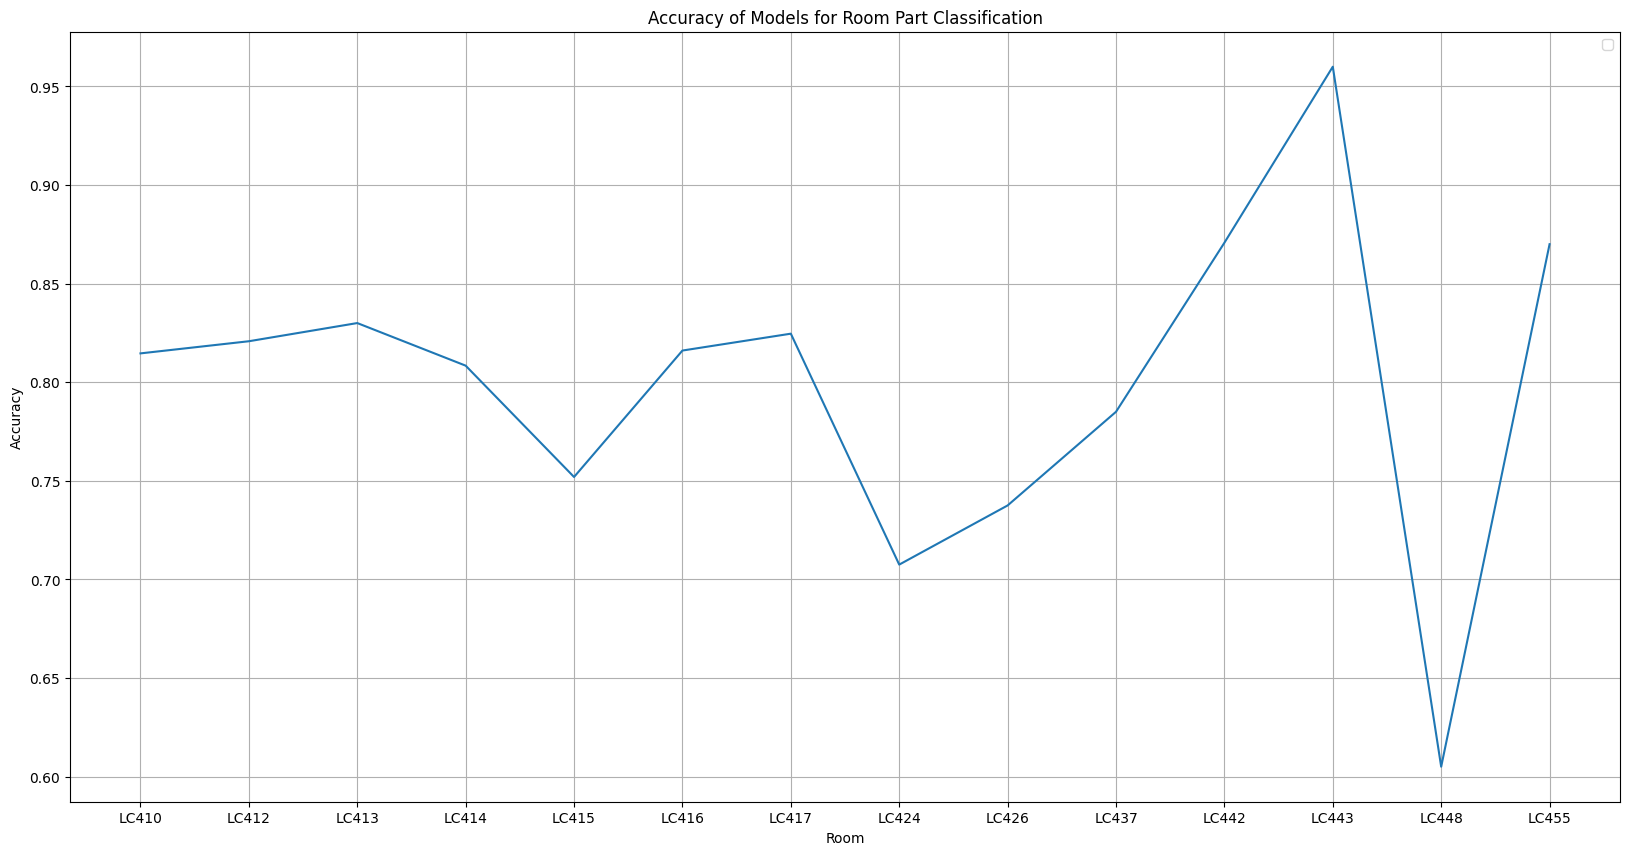

In [44]:
results2 = []
rooms = []





for id, room in data_grouped_by_room:
        train, test = train_test_split(room, test_size=0.25, train_size=0.75, random_state=42, shuffle=True)
        if len(test) > 0:

            rooms.append(id)
            tloc = TLoc(train[["room_part"] + AP_columns], pred_class="room_part")
            tloc.train()
            accuracy, prediction, ground_truth = tloc.pred(test)
            results2.append(accuracy)


plt.figure(figsize=(20, 10))


# Plotando os dados
plt.plot(rooms, results2)



# Adicionando legendas e rótulos
plt.xlabel('Room')
plt.ylabel('Accuracy')
plt.title('Accuracy of Models for Room Part Classification')
plt.legend()

# Exibindo o gráfico
plt.grid(True)
plt.show()